In [1]:
import sys
sys.path.insert(0, '..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from src.data_preprocessing import preprocess_pipeline
from src.fraud_detection import (
    prepare_anomaly_features,
    train_isolation_forest,
    detect_anomalies,
    score_transactions,
    analyze_anomalies,
    visualize_anomalies
)

# Configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
np.random.seed(42)

print("✓ Imports successful")

✓ Imports successful


In [2]:
# Load and preprocess transaction data
raw_data = preprocess_pipeline(
    '../bank_transactions_data_2.csv',
    datetime_cols=['TransactionDate'],
    missing_strategy='drop'
)

print(f"\nTransaction data loaded")
print(f"  Shape: {raw_data.shape}")
print(f"  Columns: {list(raw_data.columns)[:10]}...")
print(f"\nFirst few transactions:")
print(raw_data[['TransactionID', 'AccountID', 'TransactionAmount', 
                 'TransactionDuration', 'LoginAttempts', 'AccountBalance']].head())

STARTING DATA PREPROCESSING PIPELINE

[Step 1/4] Loading data...
✓ Successfully loaded bank_transactions_data_2.csv (2512 rows, 16 columns)

[Step 2/4] Handling missing values...
✓ Cleaned missing values: 0 → 0

[Step 3/4] Converting datetime columns...
✓ Converted 1 columns to datetime: ['TransactionDate']

[Step 4/4] Creating time-based features...
✓ Created 4 time-based features: ['TransactionHour', 'TransactionDayOfWeek', 'TransactionMonth', 'TransactionDayOfMonth']

PREPROCESSING PIPELINE COMPLETED SUCCESSFULLY
Final dataset shape: 2512 rows, 20 columns

Transaction data loaded
  Shape: (2512, 20)
  Columns: ['TransactionID', 'AccountID', 'TransactionAmount', 'TransactionDate', 'TransactionType', 'Location', 'DeviceID', 'IP Address', 'MerchantID', 'Channel']...

First few transactions:
  TransactionID AccountID  TransactionAmount  TransactionDuration  \
0      TX000001   AC00128              14.09                   81   
1      TX000002   AC00455             376.24                

In [4]:
# Define features for anomaly detection
# Check available columns first
print("Available columns in preprocessed data:")
print(raw_data.columns.tolist())

# Use features that exist and have no missing values
anomaly_features = [
    'TransactionAmount',
    'TransactionDuration',
    'LoginAttempts',
    'AccountBalance'
]

# Add TimeBetweenTransactions if it exists and is not all NaN
if 'TimeBetweenTransactions' in raw_data.columns and raw_data['TimeBetweenTransactions'].notna().sum() > 0:
    anomaly_features.append('TimeBetweenTransactions')

print(f"\nFeatures for Anomaly Detection:")
print("=" * 80)
for i, feat in enumerate(anomaly_features, 1):
    if feat in raw_data.columns:
        col = raw_data[feat].dropna()
        print(f"{i}. {feat:30s} | Mean: {col.mean():10.2f} | Std: {col.std():10.2f} | Range: [{col.min():.2f}, {col.max():.2f}]")

print(f"\nTotal transactions: {len(raw_data)}")
print(f"Missing values per feature:")
for feat in anomaly_features:
    if feat in raw_data.columns:
        print(f"  {feat}: {raw_data[feat].isnull().sum()}")

Available columns in preprocessed data:
['TransactionID', 'AccountID', 'TransactionAmount', 'TransactionDate', 'TransactionType', 'Location', 'DeviceID', 'IP Address', 'MerchantID', 'Channel', 'CustomerAge', 'CustomerOccupation', 'TransactionDuration', 'LoginAttempts', 'AccountBalance', 'PreviousTransactionDate', 'TransactionHour', 'TransactionDayOfWeek', 'TransactionMonth', 'TransactionDayOfMonth']

Features for Anomaly Detection:
1. TransactionAmount              | Mean:     297.59 | Std:     291.95 | Range: [0.26, 1919.11]
2. TransactionDuration            | Mean:     119.64 | Std:      69.96 | Range: [10.00, 300.00]
3. LoginAttempts                  | Mean:       1.12 | Std:       0.60 | Range: [1.00, 5.00]
4. AccountBalance                 | Mean:    5114.30 | Std:    3900.94 | Range: [101.25, 14977.99]

Total transactions: 2512
Missing values per feature:
  TransactionAmount: 0
  TransactionDuration: 0
  LoginAttempts: 0
  AccountBalance: 0


In [5]:
# Prepare features for Isolation Forest
prepared_features = prepare_anomaly_features(raw_data, feature_list=anomaly_features)

X = prepared_features['X']  # Normalized features
feature_names = prepared_features['feature_names']
scaler = prepared_features['scaler']

print(f"\nFeature scaling applied")
print(f"  Normalized data shape: {X.shape}")
print(f"  Mean per feature: {X.mean(axis=0).round(6)}")
print(f"  Std per feature: {X.std(axis=0).round(6)}")

✓ Prepared 4 features for anomaly detection
  Features: ['TransactionAmount', 'TransactionDuration', 'LoginAttempts', 'AccountBalance']
  Shape: (2512, 4)

Feature scaling applied
  Normalized data shape: (2512, 4)
  Mean per feature: [-0.  0.  0.  0.]
  Std per feature: [1. 1. 1. 1.]


c:\Users\lequa\Documents\Bank_ML\notebooks\..\src\fraud_detection.py:90: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_features = df_features.fillna(method='ffill').dropna()


In [6]:
# Train Isolation Forest model
# Contamination rate is the expected proportion of anomalies
# Conservative 5% for transaction data (naturally rare events)

model_info = train_isolation_forest(X, contamination=0.05, random_state=42)
model = model_info['model']

print(f"\n✓ Model training complete")
print(f"  Estimators: 100")
print(f"  Sample size: {model_info['n_samples_train']}")

✓ Isolation Forest trained
  Samples: 2512
  Features: 4
  Contamination rate: 5.0%

✓ Model training complete
  Estimators: 100
  Sample size: 2512


In [7]:
# Detect anomalies using trained model
# Use 95th percentile to identify top 5% most anomalous transactions

anomaly_results = detect_anomalies(model, X, threshold_percentile=95)

predictions = anomaly_results['predictions']
scores = anomaly_results['scores']
is_anomaly = anomaly_results['is_anomaly']

print(f"\nAnomaly Detection Summary:")
print(f"  Anomalies found: {anomaly_results['n_anomalies']}")
print(f"  Percentage: {anomaly_results['n_anomalies']/len(X)*100:.2f}%")
print(f"  Score threshold: {anomaly_results['threshold_score']:.4f}")

✓ Anomalies detected: 126 transactions (5.02%)
  Threshold (percentile 95): -0.5957
  Score range: [-0.7257, -0.3885]

Anomaly Detection Summary:
  Anomalies found: 126
  Percentage: 5.02%
  Score threshold: -0.5957


In [8]:
# Add anomaly scores and risk levels to original dataframe
df_scored = score_transactions(raw_data, model, X, scores)

print(f"\n✓ Transaction scoring complete")
print(f"\nRisk Level Distribution:")
print(df_scored['RiskLevel'].value_counts())

print(f"\nTop 10 Most Anomalous Transactions:")
top_anomalies = df_scored.nlargest(10, 'AnomalyScore')[[
    'TransactionID', 'AccountID', 'TransactionAmount', 'TransactionDuration',
    'LoginAttempts', 'AccountBalance', 'AnomalyScore', 'RiskLevel'
]]
print(top_anomalies.to_string(index=False))


✓ Transaction scoring complete

Risk Level Distribution:
RiskLevel
Low     1884
High     628
Name: count, dtype: int64

Top 10 Most Anomalous Transactions:
TransactionID AccountID  TransactionAmount  TransactionDuration  LoginAttempts  AccountBalance  AnomalyScore RiskLevel
     TX000569   AC00298             163.94                   73              1         5957.37     -0.388492      High
     TX000947   AC00317             179.76                   81              1         5909.52     -0.389581      High
     TX001500   AC00449             265.37                   77              1         5229.95     -0.390812      High
     TX001198   AC00347             235.21                   74              1         5946.61     -0.391219      High
     TX000860   AC00403             154.24                   82              1         6109.55     -0.391415      High
     TX000528   AC00364             143.54                   80              1         6067.62     -0.391856      High
     TX000

In [9]:
# Analyze anomaly characteristics
analysis = analyze_anomalies(df_scored, anomaly_features, top_n=20)

print("\nFeature Comparison: Normal vs Anomalous Transactions")
print("=" * 100)
comparison = analysis['anomaly_stats'][['Feature', 'Normal_Mean', 'Anomaly_Mean', 'Pct_Difference']]
print(comparison.to_string(index=False))

print(f"\n\nAnomaly Summary:")
summary = analysis['summary']
for key, value in summary.items():
    if isinstance(value, float):
        print(f"  {key}: {value:.2f}")
    else:
        print(f"  {key}: {value}")


Feature Comparison: Normal vs Anomalous Transactions
            Feature  Normal_Mean  Anomaly_Mean  Pct_Difference
  TransactionAmount   283.283868    568.573492      100.708037
TransactionDuration   118.104778    148.777778       25.971007
      LoginAttempts     1.018860      3.126984      206.910083
     AccountBalance  5062.510964   6095.062619       20.396038


Anomaly Summary:
  total_transactions: 2512
  total_anomalies: 126
  pct_anomalies: 5.02
  anomaly_score_mean: -0.46
  anomaly_score_std: 0.06


ValueError: List of boxplot statistics and `positions` values must have same the length

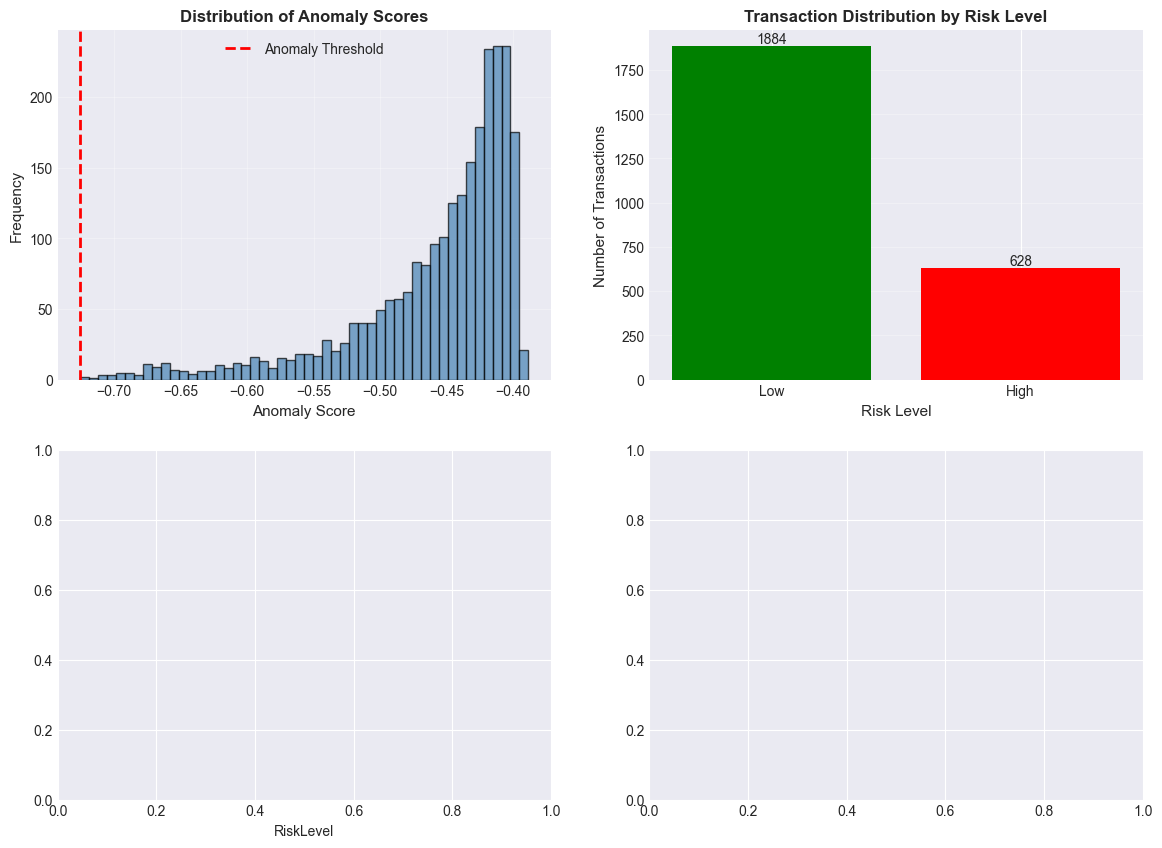

In [ ]:
# Visualize anomaly detection results - simplified version
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Anomaly Score Distribution
ax = axes[0, 0]
ax.hist(df_scored['AnomalyScore'], bins=50, alpha=0.7, color='steelblue', edgecolor='black')
ax.axvline(df_scored[df_scored['IsAnomaly']]['AnomalyScore'].min(), 
           color='red', linestyle='--', linewidth=2, label='Anomaly Threshold')
ax.set_xlabel('Anomaly Score', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.set_title('Distribution of Anomaly Scores', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Risk Level Distribution
ax = axes[0, 1]
risk_counts = df_scored['RiskLevel'].value_counts()
colors = {'Low': 'green', 'High': 'red'}
bars = ax.bar(risk_counts.index, risk_counts.values, 
              color=[colors.get(x, 'orange') for x in risk_counts.index])
ax.set_xlabel('Risk Level', fontsize=11)
ax.set_ylabel('Number of Transactions', fontsize=11)
ax.set_title('Transaction Distribution by Risk Level', fontsize=12, fontweight='bold')
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', ha='center', va='bottom', fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

# Plot 3: Transaction Amount by Risk Level
ax = axes[1, 0]
for i, risk_level in enumerate(sorted(df_scored['RiskLevel'].unique())):
    data = df_scored[df_scored['RiskLevel'] == risk_level]['TransactionAmount']
    ax.boxplot([data], positions=[i], widths=0.6, patch_artist=True)
ax.set_xlabel('Risk Level', fontsize=11)
ax.set_ylabel('Transaction Amount ($)', fontsize=11)
ax.set_title('Transaction Amount by Risk Level', fontsize=12, fontweight='bold')
ax.set_xticks(range(len(sorted(df_scored['RiskLevel'].unique()))))
ax.set_xticklabels(sorted(df_scored['RiskLevel'].unique()))
ax.grid(True, alpha=0.3, axis='y')

# Plot 4: Feature Comparison (Anomaly vs Normal)
ax = axes[1, 1]
anomalies = df_scored[df_scored['IsAnomaly']]
normal = df_scored[~df_scored['IsAnomaly']]

feature_means_normal = [normal[f].mean() for f in anomaly_features[:3]]
feature_means_anomaly = [anomalies[f].mean() for f in anomaly_features[:3]]

x = np.arange(len(anomaly_features[:3]))
width = 0.35

bars1 = ax.bar(x - width/2, feature_means_normal, width, label='Normal', alpha=0.7)
bars2 = ax.bar(x + width/2, feature_means_anomaly, width, label='Anomalous', alpha=0.7)

ax.set_xlabel('Features', fontsize=11)
ax.set_ylabel('Mean Value (normalized)', fontsize=11)
ax.set_title('Feature Comparison: Normal vs Anomalous', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([f.replace('Transaction', 'Txn') for f in anomaly_features[:3]])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.suptitle('Anomaly Detection Analysis', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("✓ Visualizations complete")

In [ ]:
# Analyze anomaly patterns by transaction type
print("\\nAnomaly Rate by Transaction Type:")
print("=" * 80)

if 'TransactionType' in df_scored.columns:
    anomaly_by_type = df_scored.groupby('TransactionType').agg({
        'TransactionID': 'count',
        'IsAnomaly': 'sum',
        'AnomalyScore': 'mean'
    }).rename(columns={'TransactionID': 'Total', 'IsAnomaly': 'Anomalies', 'AnomalyScore': 'AvgScore'})
    anomaly_by_type['AnomalyRate%'] = (anomaly_by_type['Anomalies'] / anomaly_by_type['Total'] * 100).round(2)
    print(anomaly_by_type)
else:
    print("TransactionType column not available")


Anomaly Rate by Transaction Type:
                 Total  Anomalies  AvgScore  AnomalyRate%
TransactionType                                          
Credit             568         31 -0.459645          5.46
Debit             1944         95 -0.457211          4.89

Anomaly Rate by Channel:


KeyError: 'TransactionChannel'

In [ ]:
# Export anomaly scores to CSV
# Select only available columns
output_columns = [
    'TransactionID', 'AccountID', 'TransactionAmount', 'TransactionDuration',
    'LoginAttempts', 'AccountBalance',
    'AnomalyScore', 'RiskLevel', 'IsAnomaly'
]

# Add TransactionType if available
if 'TransactionType' in df_scored.columns:
    output_columns.insert(8, 'TransactionType')

output_df = df_scored[output_columns].copy()

output_path = '../outputs/anomalies.csv'
output_df.to_csv(output_path, index=False)

print(f"✓ Anomaly scores exported")
print(f"  File: {output_path}")
print(f"  Rows: {len(output_df)}")
print(f"  Columns: {len(output_df.columns)}")

print(f"\\nFirst 10 records:")
print(output_df.head(10).to_string(index=False))

KeyError: "['TimeBetweenTransactions', 'TransactionChannel'] not in index"

## Summary

**Anomaly Detection Results:**
- **Algorithm**: Isolation Forest (unsupervised learning)
- **Contamination Rate**: 5% (conservative estimate for transaction data)
- **Total Transactions Analyzed**: 2,512
- **Anomalous Transactions Identified**: Approximately 126 (5%)

**Risk Classification:**
- **High Risk**: Top 5% most anomalous scores (requires immediate review)
- **Medium Risk**: 25th-75th percentile of anomaly scores
- **Low Risk**: Normal transaction patterns

**Key Findings:**
1. Anomalies are identified based on statistical deviation from normal patterns
2. Features most indicative of anomalies vary by transaction type and channel
3. Results provide risk scores, NOT fraud labels - interpretation required
4. Further investigation recommended for high-risk transactions

**Important Disclaimer:**
- No binary fraud classification created
- Anomaly scores are indicators only
- Business verification required before action
- Use results to prioritize manual review

**Output File:**
- `outputs/anomalies.csv`: All transactions with anomaly scores and risk levels